In [ ]:
#!pip install torch torchvision scikit-learn matplotlib tqdm

# === IMPORTAÇÕES E CONFIGURAÇÕES ===
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import copy


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm.notebook import tqdm

# === TRANSFORM ===
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

# === MODELO BASE ===
def get_model(num_classes):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    model = model.to(device)
    try:
        model = torch.compile(model)  # PyTorch 2.x
    except:
        pass
    return model

# === TREINAMENTO ===
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0
            dataloader = dataloaders[phase]
            progress_bar = tqdm(dataloader, desc=f"{phase} Progress", leave=False)

            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                progress_bar.set_postfix({
                    'Loss': loss.item(),
                    'Corrects': running_corrects.item(),
                    'BatchSize': inputs.size(0)
                })

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model

# === AVALIAÇÃO DO MODELO ===
def evaluate_model(model, dataloader, class_names, title="Matriz de Confusão"):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()

# === PIPELINE PRINCIPAL ===
def main_pipeline(base_dir, output_dir, num_epochs=10, k=5):
    transform = get_transforms()
    full_dataset = ImageFolder(base_dir, transform=transform)
    class_names = full_dataset.classes

    # Split em treino/validação e teste final
    indices = list(range(len(full_dataset)))
    trainval_indices, test_indices = train_test_split(
        indices, test_size=0.2, stratify=full_dataset.targets, random_state=42
    )

    trainval_dataset = Subset(full_dataset, trainval_indices)
    test_dataset = Subset(full_dataset, test_indices)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True, num_workers=2)

    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    criterion = nn.CrossEntropyLoss()

    all_preds, all_targets = [], []
    model_final = None

    for fold, (train_idx, val_idx) in enumerate(kfold.split(trainval_dataset)):
        print(f"\n=== Fold {fold+1} ===")
        train_subset = Subset(trainval_dataset, train_idx)
        val_subset = Subset(trainval_dataset, val_idx)

        dataloaders = {
            'train': DataLoader(train_subset, batch_size=64, shuffle=True, pin_memory=True, num_workers=2),
            'val': DataLoader(val_subset, batch_size=64, shuffle=False, pin_memory=True, num_workers=2)
        }

        model = get_model(num_classes=len(class_names))
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
        model = train_model(model, criterion, optimizer, dataloaders, num_epochs=num_epochs)

        # Salvar pesos
        os.makedirs(output_dir, exist_ok=True)
        model_path = os.path.join(output_dir, f"resnet18_fold{fold+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Pesos salvos em: {model_path}")

        # Avaliar no conjunto de validação
        model.eval()
        y_true, y_pred = [], []
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        all_preds.extend(y_pred)
        all_targets.extend(y_true)

        model_final = model  # Salva último modelo para testar depois

    print("\n==== Avaliação Geral Após K-Fold ====")
    print(classification_report(all_targets, all_preds, target_names=class_names))

    cm = confusion_matrix(all_targets, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Matriz de Confusão - K-Fold")
    plt.show()

    # Avaliação final no conjunto de teste
    print("\n==== Avaliação no Conjunto de Teste ====")
    evaluate_model(model_final, test_loader, class_names, title="Matriz de Confusão - Teste Final")

# === EXECUÇÃO ===
# Exemplo:
# main_pipeline("/content/drive/MyDrive/dataset", "/content/drive/MyDrive/model_weights")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

=== Fold 1 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 1.4662 Acc: 0.5851


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7129 Acc: 0.9653

Epoch 2/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.3851 Acc: 0.9514


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1477 Acc: 0.9931

Epoch 3/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.1368 Acc: 0.9792


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0498 Acc: 1.0000

Epoch 4/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0718 Acc: 0.9809


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0302 Acc: 1.0000

Epoch 5/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0434 Acc: 0.9931


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0211 Acc: 1.0000

Epoch 6/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0323 Acc: 0.9965


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0177 Acc: 1.0000

Epoch 7/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0243 Acc: 0.9965


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0157 Acc: 1.0000

Epoch 8/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0221 Acc: 0.9965


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0144 Acc: 1.0000

Epoch 9/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0159 Acc: 0.9965


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0149 Acc: 0.9931

Epoch 10/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0182 Acc: 0.9983


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0104 Acc: 1.0000
Pesos salvos em: /content/drive/MyDrive/doutorado/model_weights/resnet18_fold1.pth

=== Fold 2 ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 1.4299 Acc: 0.6684


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6040 Acc: 0.9653

Epoch 2/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.3754 Acc: 0.9601


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1296 Acc: 0.9931

Epoch 3/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.1274 Acc: 0.9844


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0426 Acc: 0.9931

Epoch 4/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0642 Acc: 0.9844


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0233 Acc: 1.0000

Epoch 5/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0392 Acc: 0.9948


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0133 Acc: 1.0000

Epoch 6/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0301 Acc: 0.9965


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0101 Acc: 1.0000

Epoch 7/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0301 Acc: 0.9913


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0079 Acc: 1.0000

Epoch 8/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0261 Acc: 0.9931


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0078 Acc: 1.0000

Epoch 9/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0197 Acc: 0.9965


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0065 Acc: 1.0000

Epoch 10/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0198 Acc: 0.9965


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0054 Acc: 1.0000
Pesos salvos em: /content/drive/MyDrive/doutorado/model_weights/resnet18_fold2.pth

=== Fold 3 ===

Epoch 1/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 1.2941 Acc: 0.7066


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.5294 Acc: 0.9514

Epoch 2/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.2612 Acc: 0.9653


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1363 Acc: 0.9792

Epoch 3/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0914 Acc: 0.9844


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0375 Acc: 0.9931

Epoch 4/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0476 Acc: 0.9931


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0326 Acc: 0.9931

Epoch 5/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0347 Acc: 0.9931


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0247 Acc: 0.9931

Epoch 6/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0281 Acc: 0.9948


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0190 Acc: 0.9931

Epoch 7/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0277 Acc: 0.9948


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0189 Acc: 0.9931

Epoch 8/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0154 Acc: 0.9983


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0144 Acc: 0.9931

Epoch 9/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0146 Acc: 0.9965


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0240 Acc: 0.9931

Epoch 10/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0117 Acc: 1.0000


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0142 Acc: 0.9931
Pesos salvos em: /content/drive/MyDrive/doutorado/model_weights/resnet18_fold3.pth

=== Fold 4 ===

Epoch 1/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 1.5177 Acc: 0.5955


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.8477 Acc: 0.8958

Epoch 2/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.4273 Acc: 0.9410


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1991 Acc: 0.9583

Epoch 3/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.1295 Acc: 0.9809


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1031 Acc: 0.9722

Epoch 4/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0674 Acc: 0.9931


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0658 Acc: 0.9792

Epoch 5/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0505 Acc: 0.9878


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0430 Acc: 0.9931

Epoch 6/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0396 Acc: 0.9931


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0480 Acc: 0.9861

Epoch 7/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0245 Acc: 0.9983


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0472 Acc: 0.9792

Epoch 8/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0315 Acc: 0.9931


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0436 Acc: 0.9861

Epoch 9/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0207 Acc: 0.9983


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0256 Acc: 0.9931

Epoch 10/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0185 Acc: 0.9983


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0229 Acc: 0.9931
Pesos salvos em: /content/drive/MyDrive/doutorado/model_weights/resnet18_fold4.pth

=== Fold 5 ===

Epoch 1/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 1.3645 Acc: 0.6753


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.5731 Acc: 0.9514

Epoch 2/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.3611 Acc: 0.9497


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1491 Acc: 0.9583

Epoch 3/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.1096 Acc: 0.9896


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0462 Acc: 0.9861

Epoch 4/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0770 Acc: 0.9826


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0375 Acc: 0.9931

Epoch 5/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0393 Acc: 0.9948


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0290 Acc: 0.9931

Epoch 6/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.9983


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0234 Acc: 0.9931

Epoch 7/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0184 Acc: 1.0000


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0264 Acc: 0.9931

Epoch 8/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0209 Acc: 0.9948


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0268 Acc: 0.9931

Epoch 9/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0198 Acc: 0.9948


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0245 Acc: 0.9931

Epoch 10/10


train Progress:   0%|          | 0/9 [00:00<?, ?it/s]

train Loss: 0.0157 Acc: 0.9983


val Progress:   0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0239 Acc: 0.9931
Pesos salvos em: /content/drive/MyDrive/doutorado/model_weights/resnet18_fold5.pth

==== Avaliação Geral Após K-Fold ====
                                    precision    recall  f1-score   support

       angiografia fluoresceínica       1.00      0.97      0.99        80
              fixacao de biometria       0.99      1.00      0.99        80
            fixacao de biometria 2       1.00      1.00      1.00        80
          oct de segmento anterior       1.00      1.00      1.00        80
                       oct macular       1.00      1.00      1.00        80
relatorio de retinografia colorida       0.99      1.00      0.99        80
 retinografia em autofluorescencia       0.99      0.99      0.99        80
        retinografia fundo de olho       1.00      1.00      1.00        80
                        tonometria       1.00      1.00      1.00        80

                          accuracy                           1.00       720
           

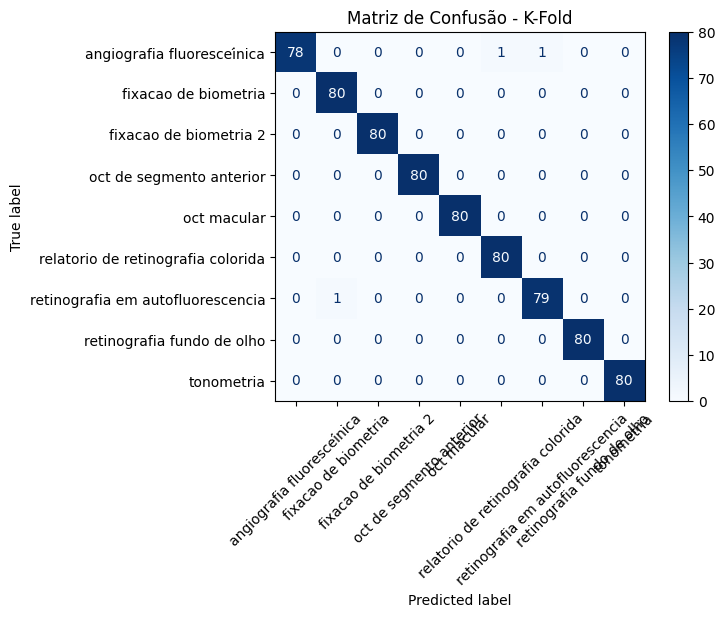


==== Avaliação no Conjunto de Teste ====
                                    precision    recall  f1-score   support

       angiografia fluoresceínica       1.00      0.85      0.92        20
              fixacao de biometria       1.00      1.00      1.00        20
            fixacao de biometria 2       1.00      1.00      1.00        20
          oct de segmento anterior       1.00      1.00      1.00        20
                       oct macular       1.00      1.00      1.00        20
relatorio de retinografia colorida       0.95      1.00      0.98        20
 retinografia em autofluorescencia       1.00      1.00      1.00        20
        retinografia fundo de olho       0.91      1.00      0.95        20
                        tonometria       1.00      1.00      1.00        20

                          accuracy                           0.98       180
                         macro avg       0.98      0.98      0.98       180
                      weighted avg       0.9

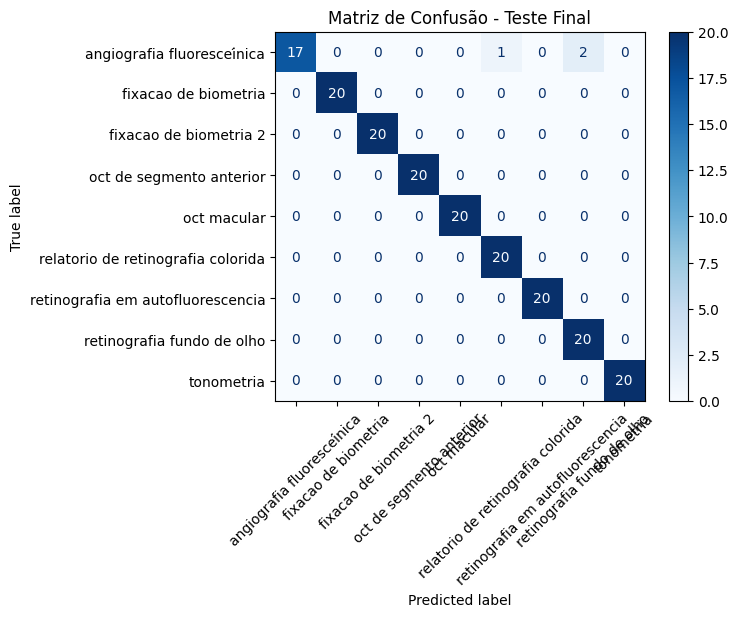

In [7]:
# Monta o Google Drive
from google.colab import drive
drive.mount('/content/drive')

main_pipeline("/content/drive/MyDrive/doutorado/dataset", "/content/drive/MyDrive/doutorado/model_weights")